# Shifts and Lags

In [ ]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(ggridges)
library(sdazar)
library(data.table)
library(MASS)
library(stringr)

# library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [2]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

In [3]:
country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

In [5]:
df[, ctry := factor(ctry, labels=country_labels)]

In [6]:
# intrapolation?
# x <- 1:10
# y <- rnorm(10)

# plot(x, y, main = "approx(.) and approxfun(.)")
# # points(approx(x, y), col = 2, pch = "*")
# points(approx(y, method = "linear"), col = 4, pch = "*")

# Male

In [6]:
male = df[tseries2==1 & sex==1 & age==0]

male = male[complete.cases(male[, .(Ex, gdp_pc)])]

male = male[, .(ctry, year, gdp_pc, Ex)]
setnames(male, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [7]:
male[, le_log := scale(log(le), scale=FALSE)]
male[, gdp_log := scale(log(gdp), scale=FALSE)]
male[, year_log := scale(log(year), scale=FALSE)]

In [8]:
# year recode based on the criteria proposed by Alberto
male[year<1950, gyear:=1]
male[year>=1950 & year<1970, gyear:=2]
male[year>=1970 & year<1990, gyear:=3]
male[year>=1990, gyear :=4]
male[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [9]:
# transform variable: weibull
male[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
male[, wy := log(-log(1-y))]

In [10]:
max_le_male = male[, .(max_le = max(le+1.05)), by = ctry]

In [11]:
# function
get_orig_values_weibull = function(x, max_value) { 
    return ( (1 - exp(-exp(x))) * max_value )
}

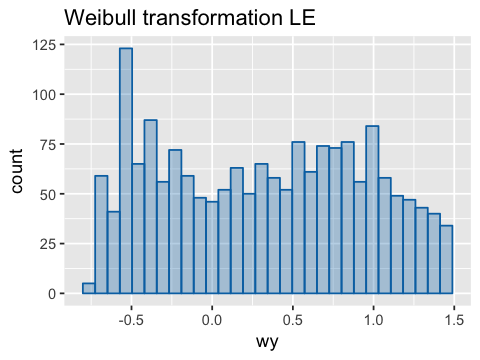

In [12]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(male, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

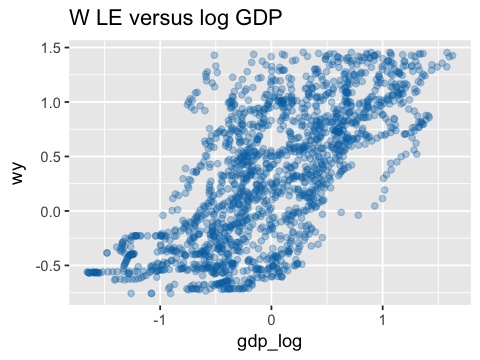

In [13]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(male, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

## Male Model

In [14]:
# check sample sizes
male[, ctry_year := interaction(ctry, gyear)]

In [15]:
m1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = male)

Compiling the C++ model
Start sampling


In [16]:
summary(m1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: male (Number of observations: 1772) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.56      0.05     0.47     0.67        834 1.00
sd(gdp_log)                0.69      0.07     0.57     0.84       1476 1.00
cor(Intercept,gdp_log)    -0.00      0.13    -0.26     0.25        820 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.39      0.06     0.25     0.52        473 1.00
gdp_log       0.74      0.09     0.58     0.91        952 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00 

### Examine GOF

In [158]:
pred = cbind(male[, .(ctry, year, le, gdp_log, le_log)], predict(m1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [159]:
pred = merge(pred, max_le_male, by = 'ctry')

In [21]:
# head(pred, 10)

In [160]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_le), 
    lo = get_orig_values_weibull(lo, max_le),
    hi = get_orig_values_weibull(hi, max_le)
    )]

In [161]:
pred_male = pred

In [24]:
max_ex = max(male$le)+25.0
min_ex = min(male$le)-25.0
max_year = max(male$year)
min_year = min(male$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

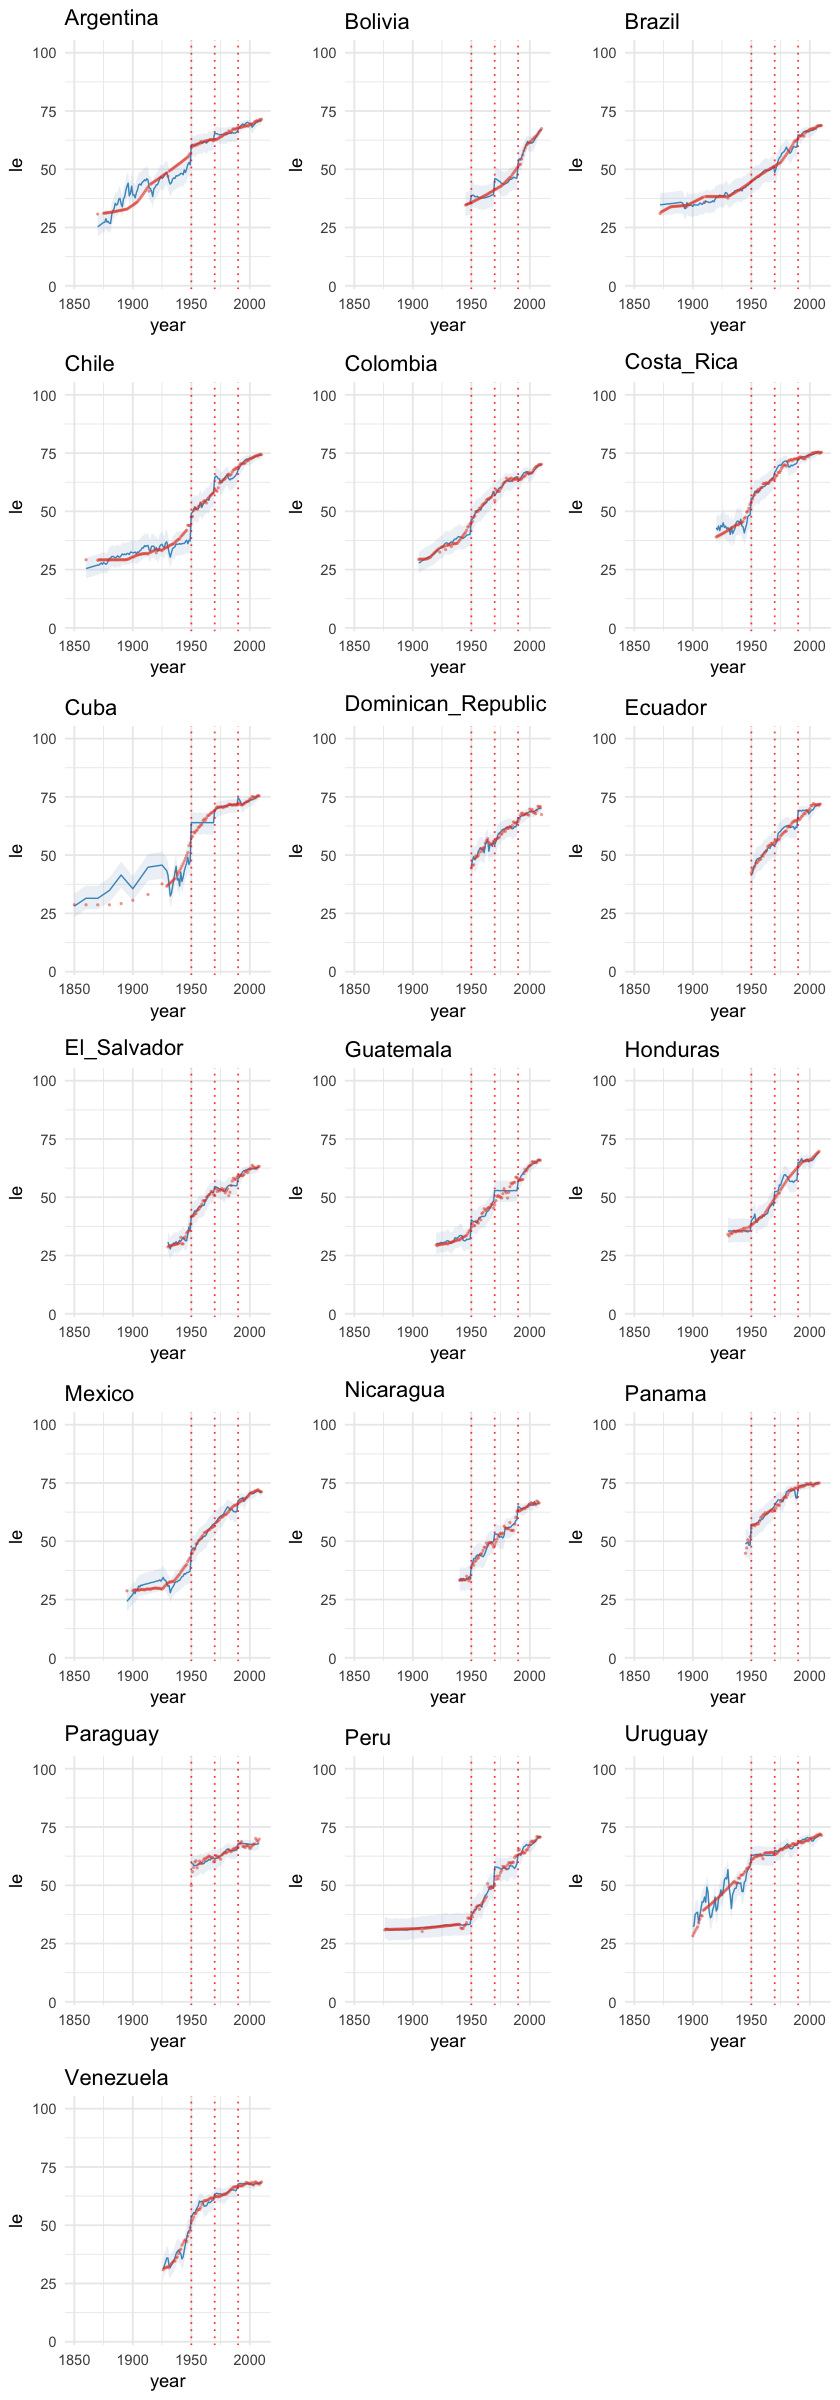

In [25]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))

# Female

In [43]:
female = df[tseries2==1 & sex==2 & age==0]

female = female[complete.cases(female[, .(Ex, gdp_pc)])]

female = female[, .(ctry, year, gdp_pc, Ex)]
setnames(female, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [44]:
female[, le_log := scale(log(le), scale=FALSE)]
female[, gdp_log := scale(log(gdp), scale=FALSE)]
female[, year_log := scale(log(year), scale=FALSE)]

In [45]:
# year recode based on the criteria proposed by Alberto
female[year<1950, gyear:=1]
female[year>=1950 & year<1970, gyear:=2]
female[year>=1970 & year<1990, gyear:=3]
female[year>=1990, gyear :=4]
female[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [46]:
# transform variable: weibull
female[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
female[, wy := log(-log(1-y))]

In [47]:
max_le_female = female[, .(max_le = max(le+1.05)), by = ctry]

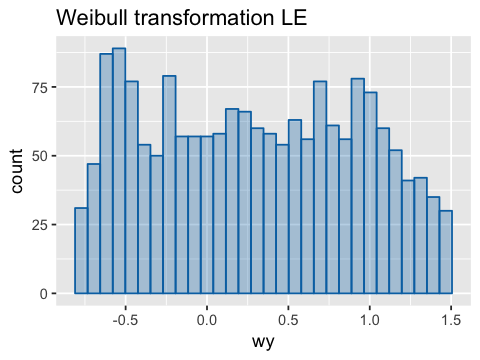

In [31]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(female, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

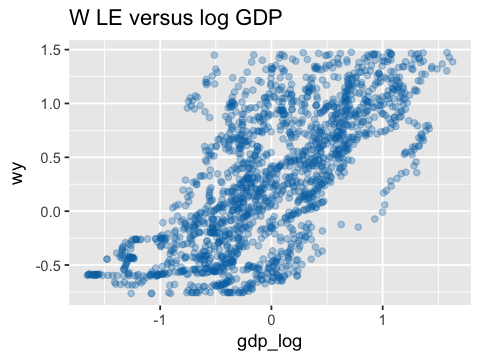

In [32]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(female, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

## Female Model

In [48]:
# check sample sizes
female[, ctry_year := interaction(ctry, gyear)]

In [49]:
f1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = female)

Compiling the C++ model
Start sampling


In [50]:
summary(f1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: female (Number of observations: 1772) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.53      0.05     0.45     0.63        582 1.00
sd(gdp_log)                0.69      0.07     0.57     0.83       1174 1.00
cor(Intercept,gdp_log)     0.07      0.13    -0.18     0.33        634 1.01

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.33      0.07     0.20     0.46        370 1.01
gdp_log       0.75      0.08     0.58     0.91        527 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.0

### Examine GOF

In [162]:
pred = cbind(female[, .(ctry, year, le, gdp_log, le_log)], predict(f1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [163]:
pred = merge(pred, max_le_female, by = 'ctry')

In [164]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_le), 
    lo = get_orig_values_weibull(lo, max_le),
    hi = get_orig_values_weibull(hi, max_le)
    )]

In [165]:
pred_female = pred

In [53]:
max_ex = max(female$le)+25.0
min_ex = min(female$le)-25.0
max_year = max(female$year)
min_year = min(female$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

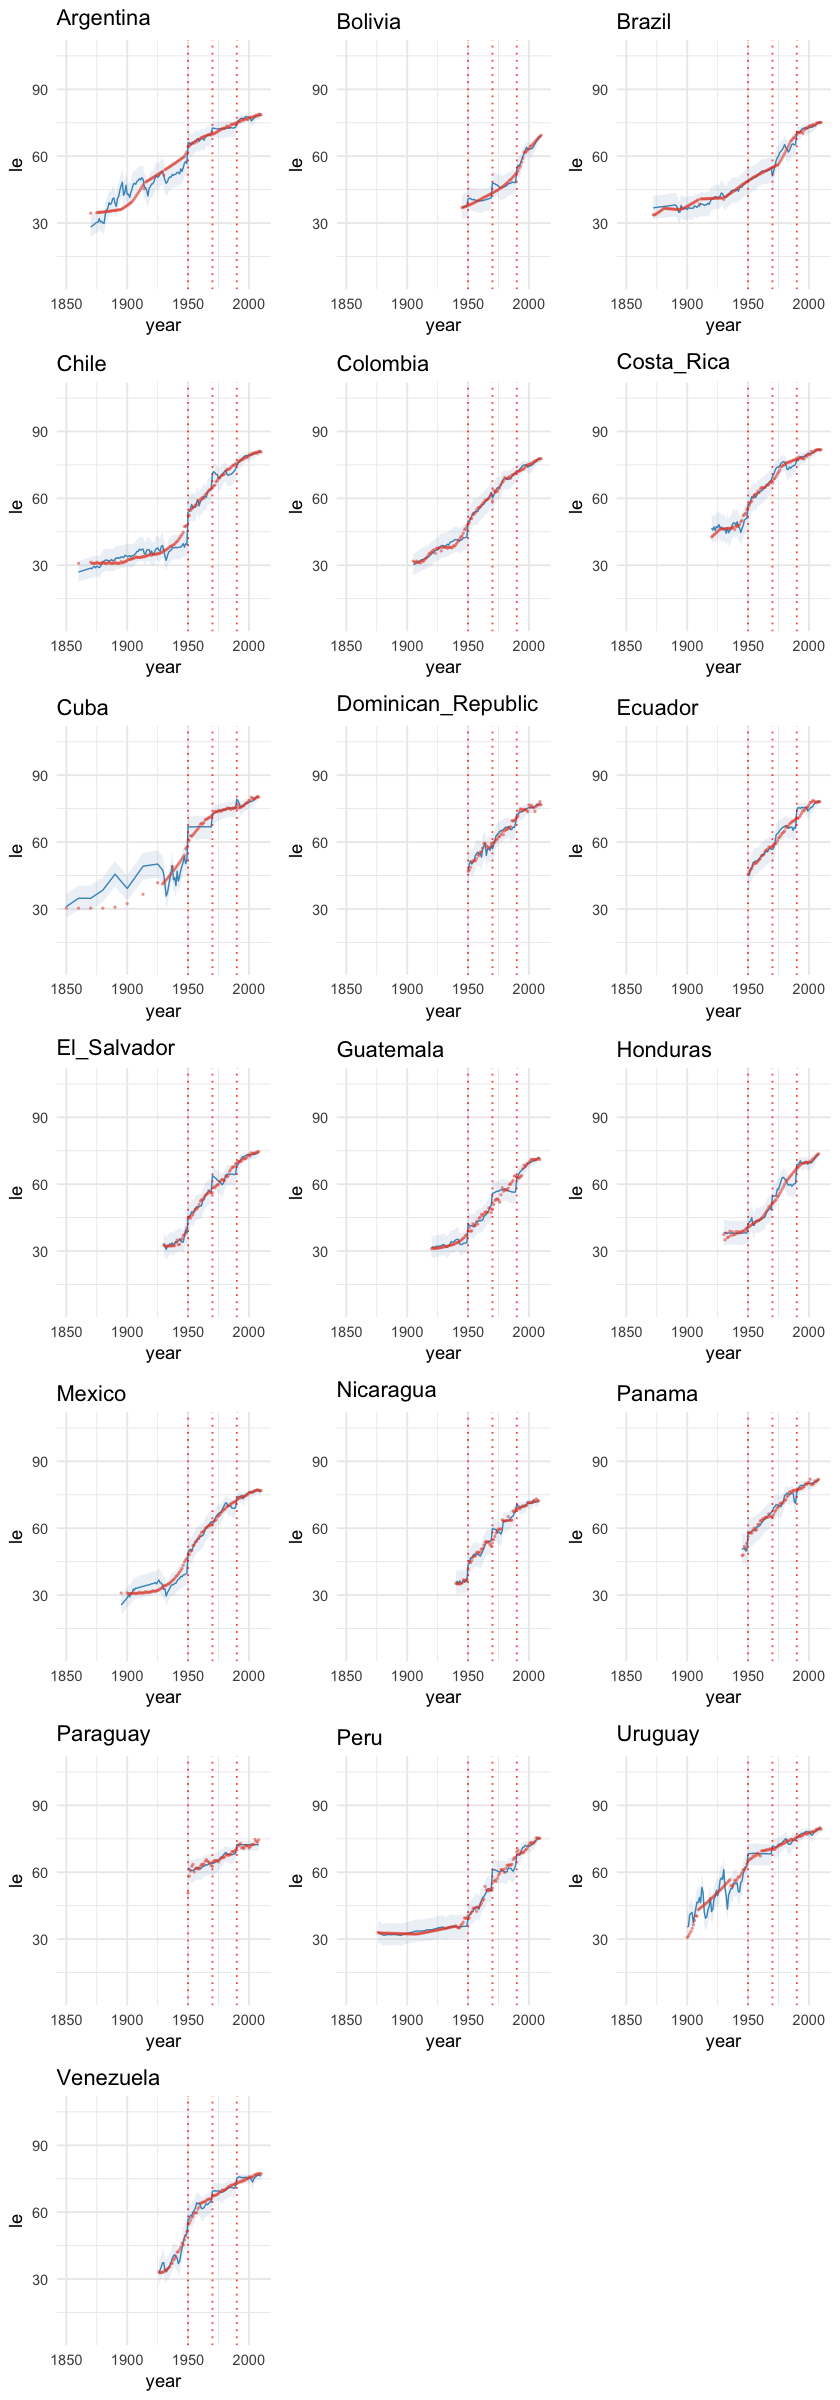

In [54]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))

# Average Male - Female

In [51]:
total = df[tseries2==1 & age==0, # average life expectancies
           .(Ex=mean(Ex), 
             gdp_pc=max(gdp_pc)
            ), 
           by=.(ctry, year)]

In [52]:
total = total[complete.cases(total[, .(Ex, gdp_pc)])]

total= total[, .(ctry, year, gdp_pc, Ex)]
setnames(total, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [53]:
total[, le_log := scale(log(le), scale=FALSE)]
total[, gdp_log := scale(log(gdp), scale=FALSE)]
total[, year_log := scale(log(year), scale=FALSE)]

In [54]:
# year recode based on the criteria proposed by Alberto
total[year<1950, gyear:=1]
total[year>=1950 & year<1970, gyear:=2]
total[year>=1970 & year<1990, gyear:=3]
total[year>=1990, gyear :=4]
total[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [55]:
# transform variable: weibull
total[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
total[, wy := log(-log(1-y))]

In [56]:
max_le_total = total[, .(max_le = max(le+1.05)), by = ctry]

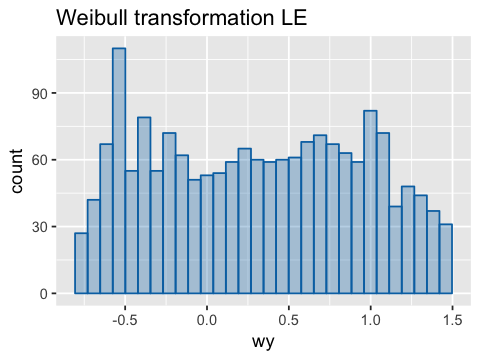

In [61]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(total, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

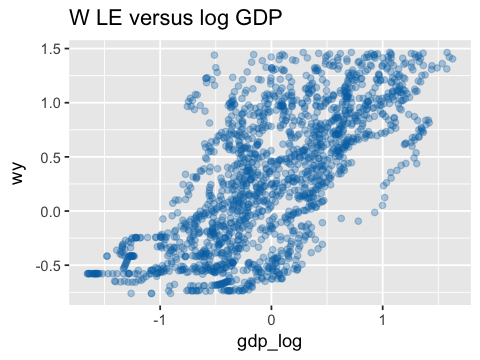

In [62]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(total, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

## Total Model

In [57]:
# check sample sizes
total[, ctry_year := interaction(ctry, gyear)]

In [58]:
t1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = total)

Compiling the C++ model
Start sampling


In [59]:
summary(t1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: total (Number of observations: 1772) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.54      0.05     0.45     0.65        768 1.01
sd(gdp_log)                0.69      0.07     0.57     0.83       1048 1.01
cor(Intercept,gdp_log)     0.05      0.13    -0.22     0.30        790 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.36      0.06     0.24     0.49        307 1.01
gdp_log       0.75      0.08     0.58     0.91        755 1.01

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00

### Examine GOF

In [166]:
pred = cbind(total[, .(ctry, year, le, gdp_log, le_log)], predict(t1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [167]:
pred = merge(pred, max_le_total, by = 'ctry')

In [168]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_le), 
    lo = get_orig_values_weibull(lo, max_le),
    hi = get_orig_values_weibull(hi, max_le)
    )]

In [169]:
pred_total = pred

In [72]:
max_ex = max(total$le)+25.0
min_ex = min(total$le)-25.0
max_year = max(total$year)
min_year = min(total$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

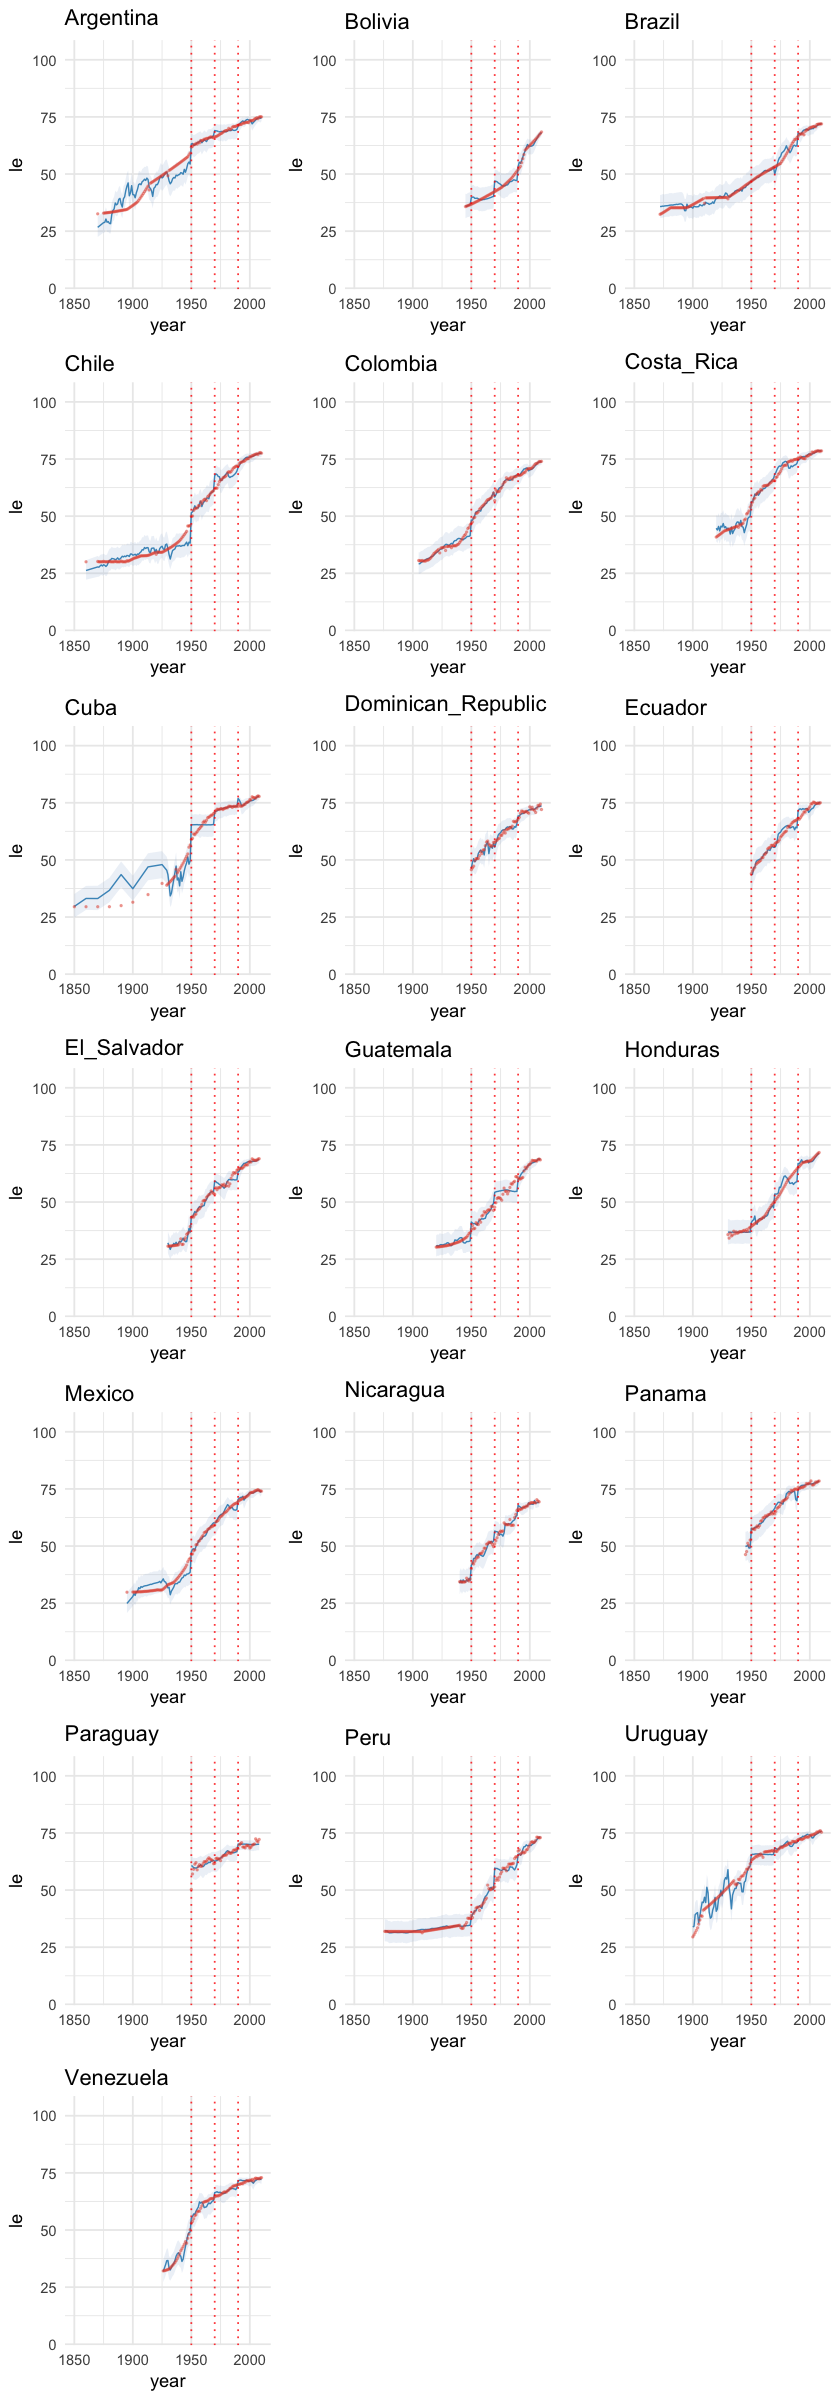

In [73]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))

In [170]:
# get predictions
pred_male[, sex := 'male']
pred_female[, sex := 'female']
pred_total[, sex := 'total']

pred = rbind(pred_male, pred_female, pred_total)
fwrite(pred[sex=='total', .(ctry, year, sex, le, m, lo, hi)], 'pred.csv')

# Compute shifts

In [184]:
estimate_shift = function(samples,
                          gdp_value=NULL,
                          le_value=NULL,
                          country=NULL, 
                          model_year=NULL,
                          year=NULL,
                          max_le = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
                          
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))
    s = samples[, c(betas, random)]  
                                 
    pred = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_value
    pred = unlist(sapply(pred, function(x) get_orig_values_weibull(x, max_value=max_le)))
    
    return(le_value-pred)           
}

In [185]:
test = estimate_shift(samples=posterior_samples(m1), 
               country='Argentina',
               le_value=male[ctry=='Argentina' & year==1950,le],
               gdp_value=male[ctry=='Argentina' & year==1950, gdp_log],
               year=1950, 
               model_year='1950',
               max_le=max_le_male[ctry=='Argentina', max_le])

In [186]:
compute_shifts = function(model, 
                          data, 
                          country_labels,
                          iyears, 
                          max_le,
                          coefficients,
                          predicted_le=FALSE) {
        
    samples = posterior_samples(model)
    colnames = names(samples)

    model_pred = list('1950' = '1950-1969', '1970' = '1970-1989', '1990' = '1990', '2010'= '1990')
    
    shifts = list()

    for (c in country_labels) {
        
        years = as.numeric(data[ctry==c & year %in% iyears, year])
        segments = as.character(unique(data[ctry==c, gyear]))
        max_le_value = max_le[ctry==c, max_le]
        
        for (ys in years) {
            
             if (predicted_le) {
                 
                 betas = paste0('b_', coefficients)
                 my = model_pred[[as.character(ys)]]
     
                 random = str_subset(colnames, paste0('^r_.+\\[', c, '.', my, ','))
                 s = samples[, c(betas, random)]

                 gdp_log = data[ctry==c & year==year, gdp_log]
                 
                 le_value = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_log[1]
                 
                 le_value = unlist(sapply(le_value, function(x) get_orig_values_weibull(x, max_value=max_le_value)))
            } 
            else {
                le_value = data[ctry==c & year==year, le][1]
            }
                                          
            for (ysm in segments) {
               
               est = estimate_shift(samples=samples, 
                   le_value=le_value, 
                   gdp_value = data[ctry==c & year==ys, gdp_log],
                   country=c, 
                   year=ys, 
                   model_year=ysm,
                   max_le=max_le_value, 
                   coefficients=coefficients)
            
            name = paste0(c(c,ys,ysm), collapse='.')
            shifts[[paste0(c(c,ys,ysm), collapse='.')]] = data.table(name, pred_shift = est)
                
            }
        }   
        
     }
       shifts = rbindlist(shifts)
       shifts[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

       levels = c('1990', '1970-1989', '1950-1969', '1950')
       labels = c('>=1990', '1970-1989', '1950-1969', '<1950')
       shifts[, segment := factor(segment, levels=levels, 
                             labels=labels ) ] 

        return(shifts)
}

In [187]:
iyears = c(1950, 1970, 1990, 2010)

shift_male_obs = compute_shifts(model=m1, 
                             data=male, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_male, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=FALSE)

shift_male_pred = compute_shifts(model=m1, 
                             data=male, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_male, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=TRUE)

In [188]:
shift_female_obs = compute_shifts(model=f1, 
                             data=female, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_female, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=FALSE)

shift_female_pred = compute_shifts(model=f1, 
                             data=female, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_female, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=TRUE)

In [189]:
shift_female_obs = compute_shifts(model=t1, 
                             data=total, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_total, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=FALSE)

shift_female_pred = compute_shifts(model=t1, 
                             data=total, 
                             country_labels=country_labels, 
                             iyears=iyears,
                             max_le=max_le_total, 
                             coefficients = c('Intercept', 'gdp_log'),
                             predicted_le=TRUE)

In [190]:
shift_male_obs[, sex := 'male']
shift_male_pred[, sex := 'male']

shift_female_obs[, sex := 'female']
shift_female_pred[, sex := 'female']

shift_total_obs[, sex := 'total']
shift_total_pred[, sex := 'total']

In [191]:
shift_obs = rbind(shift_total_obs, shift_male_obs, shift_female_obs)
shift_pred = rbind(shift_total_pred, shift_male_pred, shift_female_pred)

In [42]:
# head(shift_male_obs, 5)
# head(shift_male_pred, 5)

In [192]:
dim(shift_obs)

[1] 3096000       6

In [193]:
dim(shift_pred)

[1] 3096000       6

In [194]:
sample_shift_pred = shift_pred[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, segment, sex)]
sample_shift_obs = shift_obs[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, segment, sex)]

In [195]:
# sample values to increase speed of app
fwrite(sample_shift_pred[sex=='total',.(ctry, year, segment, sex, pred_shift)], 'shifts_pred.csv')
fwrite(sample_shift_obs[sex=='total',.(ctry, year, segment, sex, pred_shift)], 'shifts_obs.csv')

# Lags

In [196]:
estimate_lags = function(samples, 
                         country=NULL, 
                         model_year=NULL,
                         le_values=NULL,
                         year_values=NULL,
                         year=NULL,
                         gdp_value = NULL, 
                         max_le_value = NULL,
                         predicted_le = FALSE, 
                         coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
    betas = paste0('b_', coefficients)
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))

    s = samples[, c(betas, random)]

    pred = (s[,1] + s[,3]) + (s[,2] + s[,4]) * gdp_value
    pred = unlist(sapply(pred, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
     
    ind = NULL
    for (i in 1:length(pred)) {
        ind[i] = which.min(abs(le_values - pred[i]))
        }
           
    return(year_values[ind]-year)
}

In [197]:
compute_lags = function(model,
                        data, 
                        country_labels, 
                        iyears,
                        max_le, 
                        predicted_le=FALSE, 
                        coefficients) {

    model_years = list('1950' = '1950', '1970' = '1950-1969', '1990' = '1970-1989')
    samples = posterior_samples(model)
    
    lags = list()

    for (c in country_labels) {
    
    max_le_value = max_le[ctry==c, max_le]
    iyears = as.numeric(data[ctry==c & year %in% iyears, year])
    segments = as.character(unique(data[ctry==c, gyear]))
        
      if (predicted_le) {
          le_values = predict(model, data[ctry==c], summary=FALSE)
          le_values = apply(le_values, 2, mean)
          le_values = unlist(lapply(le_values,  function(x) 
              get_orig_values_weibull(x, max_le_value)))
          year_values = data[ctry==c, year]
        } else { 
        le_values = data[ctry==c, le]
        year_values = data[ctry==c, year]       
        }
    
    for (ys in iyears) {
        
            tv = model_years[[as.character(ys)]]
            
            if (!(tv %in% segments)) { next }
            
            gdp_value= data[ctry==c & year==ys, gdp_log]

            est = estimate_lags(samples=samples, 
                         country=c, 
                         model_year=tv,
                         le_values=le_values,
                         year=ys,
                         year_values=year_values,
                         gdp_value=gdp_value, 
                         max_le_value=max_le_value,
                         predicted_le=predicted_le
                     )

                name = paste0(c(c,ys,tv), collapse='.')
                lags[[paste0(c(c,ys,tv), collapse='.')]] = data.table(name, pred_lag = est)

                  }

            }


       lags = rbindlist(lags)
       lags[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

       return(lags)
}

In [198]:
iyears = c(1950, 1970, 1990)

In [199]:
lags_male_obs = compute_lags(model=m1, 
                        data=male, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le_male, 
                        predicted_le=FALSE)

lags_male_pred = compute_lags(model=m1, 
                        data=male, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le_male, 
                        predicted_le=TRUE)

lags_male_obs[, sex := 'male']
lags_male_pred[, sex := 'male']

In [200]:
lags_female_obs = compute_lags(model=f1, 
                        data=female, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le_female, 
                        predicted_le=FALSE)

lags_female_pred = compute_lags(model=f1, 
                        data=female, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le_female, 
                        predicted_le=TRUE)

lags_female_obs[, sex := 'female']
lags_female_pred[, sex := 'female']

In [201]:
lags_total_obs = compute_lags(model=t1, 
                        data=total, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le_total, 
                        predicted_le=FALSE)

lags_total_pred = compute_lags(model=m1, 
                        data=male, 
                        country_labels=country_labels, 
                        iyears=iyears,
                        max_le=max_le_total, 
                        predicted_le=TRUE)

lags_total_obs[, sex := 'total']
lags_total_pred[, sex := 'total']

In [202]:
lags_obs = rbind(lags_total_obs, lags_male_obs, lags_female_obs)
lags_pred = rbind(lags_total_pred, lags_male_pred, lags_female_pred)

In [203]:
dim(lags_obs)

[1] 648000      6

In [204]:
dim(lags_pred)

[1] 648000      6

In [205]:
sample_lags_pred = lags_pred[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, sex)]
sample_lags_obs = lags_obs[,.SD[sample(.N, min(1000,.N))], by=.(ctry, year, sex)]

In [206]:
# sample values to increase speed of app
fwrite(sample_lags_pred[sex=='total',.(ctry, year, sex, pred_lag)], 'lags_pred.csv')
fwrite(sample_lags_obs[sex=='total',.(ctry, year, sex, pred_lag)], 'lags_obs.csv')